In [2]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

### Collect data

In [5]:
DATASET_ID = 'zebra_finch_theunisson'

In [6]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [7]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'zf_library.pickle'

In [8]:
syllable_df = pd.read_pickle(df_loc)

In [9]:
syllable_df[:3]

,start_time,end_time,indv,indvi,vocalization_type,key,audio,rate,spectrogram
0,0.0,0.090907,BlaBla0506,0,Te,BlaBla0506_110302-TetC-12,"[-0.00010242089339890763, -0.00057870499781021...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,0.0,0.259569,GreGre2522,0,Wh,GreGre2522_130417-Wh-01,"[-4.138217915107379e-06, -1.0298563472850973e-...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,0.0,0.063991,GraGra0201,0,Th,GraGra0201_110907-ThuckC-38,"[-6.724604112049491e-05, -0.000377366215625527...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [10]:
len(syllable_df)

3348

### cluster

In [11]:
syllable_df = syllable_df[syllable_df['vocalization_type'].isin(['Be', 'Ne', 'So', 'Wh','WC'])==False]

In [12]:
len(syllable_df)

2144

In [13]:
specs = list(syllable_df.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(2144, 1120)

In [14]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [15]:
fit = umap.UMAP()

In [16]:
cuml_umap = cumlUMAP()
z = list(cuml_umap.fit_transform(specs_flattened))

In [17]:
np.shape(specs_flattened)

(2144, 1120)

In [18]:
z = np.vstack(z)

### variation across populations

In [19]:
call_dict = {
    "Ag": "Wsst or aggressive call",
    "Be": "Begging calls",
    "DC": "Distance call",
    "Di": "Distress call",
    "LT": "Long Tonal call",
    "Ne": "Nest call",
    "So": "Song",
    "Te": "Tet call",
    "Th": "Thuk call",
    "Tu": "Tuck call",
    "Wh": "Whine call",
}

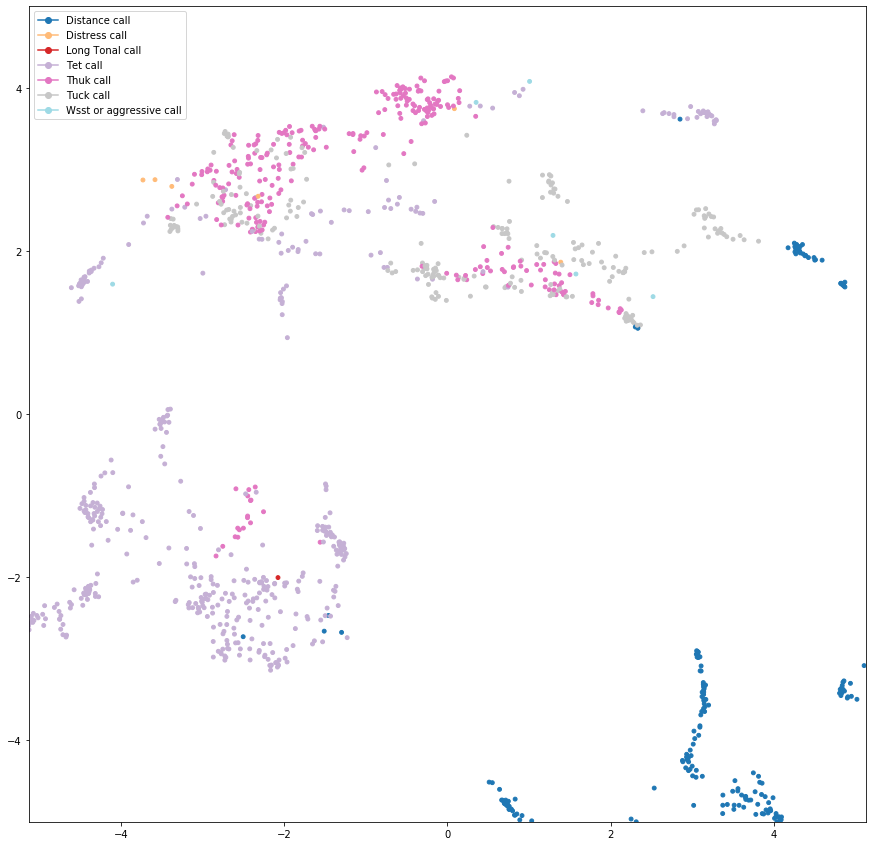

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=1, labels = [call_dict[i] for i in syllable_df.vocalization_type.values], s=15, ax = ax)
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
plt.show()

In [21]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [22]:
call_labels = [call_dict[i] for i in syllable_df.vocalization_type.values]

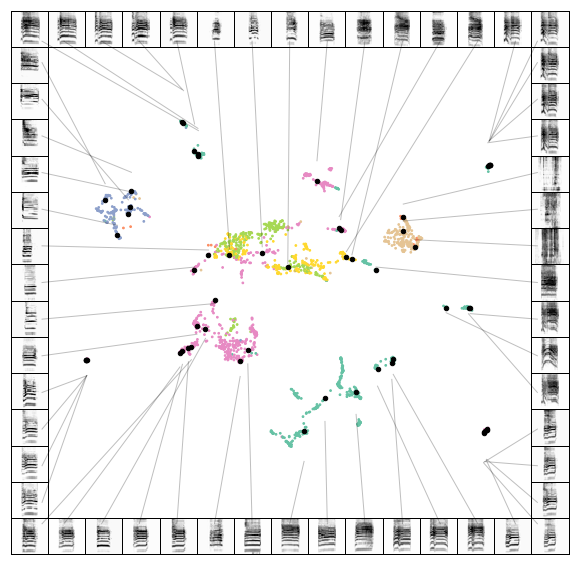

In [23]:
scatter_spec(
    z,
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': call_labels,
        'alpha':1,
        's': 3,
        'show_legend': False,
        'color_palette': 'Set2',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
#save_fig(FIGURE_DIR / 'zf_syllables', dpi=300, save_jpg=True)

#### individuals by call type

In [24]:
syllable_df[:3]

,start_time,end_time,indv,indvi,vocalization_type,key,audio,rate,spectrogram
0,0.0,0.090907,BlaBla0506,0,Te,BlaBla0506_110302-TetC-12,"[-0.00010242089339890763, -0.00057870499781021...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,0.0,0.063991,GraGra0201,0,Th,GraGra0201_110907-ThuckC-38,"[-6.724604112049491e-05, -0.000377366215625527...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,0.0,0.094535,GreRas2400,0,Te,GreRas2400_110615_TetC-07,"[-4.552039706618117e-05, -0.000208463210248830...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [25]:
call_df = syllable_df[syllable_df.vocalization_type == 'DC']

In [26]:
{i:np.sum(call_df.indv == i) for i in call_df.indv.unique()}

{'BluRas07dd': 27,
 'YelOra2575': 47,
 'BlaBla0506': 21,
 'GreGre6364': 14,
 'WhiLbl0010': 26,
 'WhiBlu5698': 12,
 'WhiGra0114': 8,
 'BlaLbl8026': 25,
 'LblRed0613': 36,
 'BluRas61dd': 35,
 'RedRas3600': 10,
 'GraLbl0457': 26,
 'WhiWhi1415': 5,
 'GreOra1817': 24,
 'GraGra0201': 41,
 'YelGre5275': 38,
 'WhiRas44dd': 30,
 'LblBla4419': 40,
 'GreWhi1242': 3,
 'LblBla4548': 44,
 'HPiHPi4748': 29,
 'WhiBlu4818': 5,
 'PurRas20dd': 28,
 'WhiBlu4917': 9,
 'GreRas2400': 2}

In [27]:
indvs_to_include = [i for i in call_df.indv.unique() if np.sum(call_df.indv == i) > 15]

In [28]:
call_df = call_df[call_df.indv.isin(indvs_to_include)]

In [29]:
specs = list(call_df.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(517, 1120)

In [30]:
cuml_umap = cumlUMAP(min_dist=0.25)
z = list(cuml_umap.fit_transform(specs_flattened))

np.shape(specs_flattened)

z = np.vstack(z)

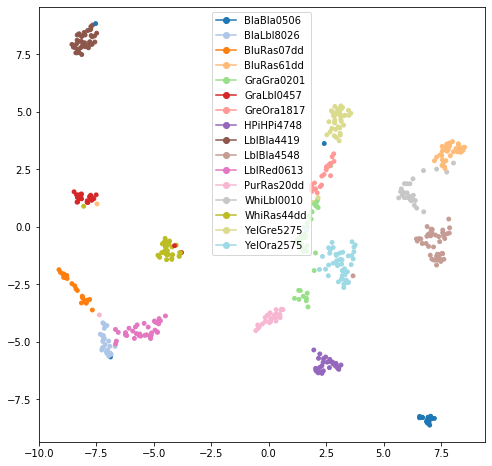

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
scatter_projections(projection=z, alpha=1, labels = call_df.indv.values, s=15, ax = ax)
#ax.set_xlim([-15,15])
#ax.set_ylim([-15,15])
plt.show()

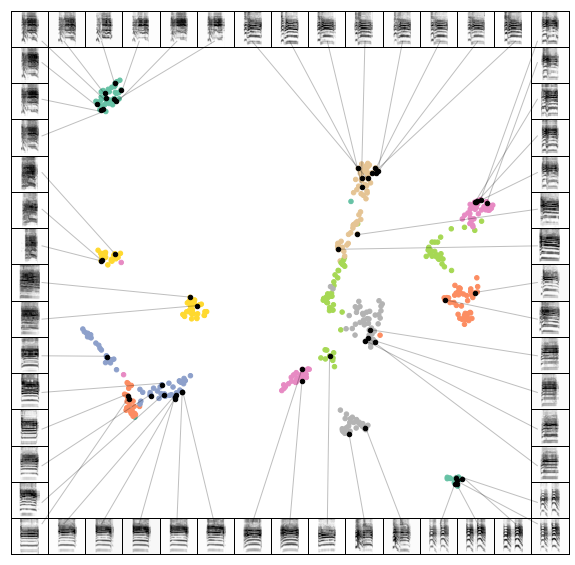

In [32]:
scatter_spec(
    z,
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': call_df.indv.values,
        'alpha':1,
        's': 20,
        'show_legend': False,
        'color_palette': 'Set2',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
#save_fig(FIGURE_DIR / 'zf_distance', dpi=300, save_jpg=True)

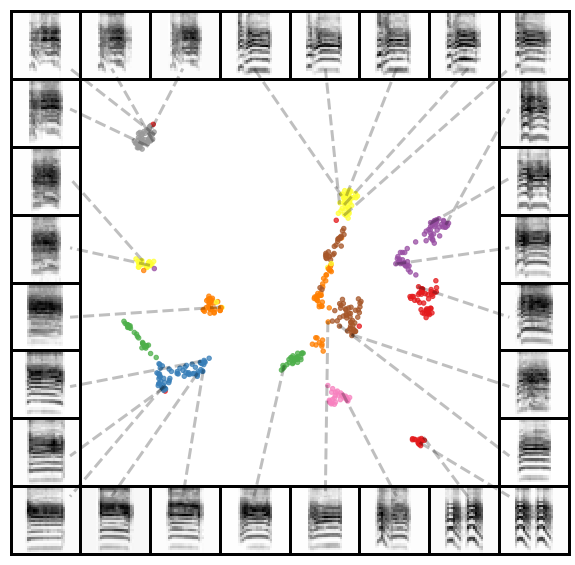

In [33]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': call_df.indv.values,
        'alpha':0.75,
        's': 20,
        'show_legend': False,
        "color_palette": 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'indv' / 'zf', dpi=300, save_jpg=True, save_png=True)

### get silhouette score

In [37]:
from scipy.stats import kruskal

In [38]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [41]:
samples = silhouette_samples(list(z), labels = call_df.indv.values)
chance_samples = silhouette_samples(list(z), labels = np.random.permutation(call_df.indv.values))

In [42]:
kruskal(samples, chance_samples)

KruskalResult(statistic=588.7592662038019, pvalue=4.664299247221036e-130)

In [43]:
print(np.mean(samples))

0.5872841074833781


### Save for paper

In [46]:
call_df[:3]

,start_time,end_time,indv,indvi,vocalization_type,key,audio,rate,spectrogram
0,0.0,0.184853,BluRas07dd,0,DC,BluRas07dd_110429-DC-18,"[-2.2760198533090584e-05, 5.4311696259303226e-...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0..."
0,0.0,0.228118,YelOra2575,0,DC,YelOra2575_110630-DC-40,"[-0.00030208990780283867, -0.00164771931213886...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,0.0,0.308481,BlaBla0506,0,DC,BlaBla0506_110304-DC-25,"[-1.551831718165267e-05, -8.827822800447969e-0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [47]:
call_df['umap_spectrogram'] = list(z)
call_df['silhouette'] = list(samples)

In [49]:
ensure_dir(DATA_DIR / "paper_data" / "indv_id" / 'zf')
call_df.to_pickle(DATA_DIR / "paper_data" / "indv_id" / 'zf' / "zebra_finch.pickle")

#### individuals by call type

In [ ]:
syllable_df[:3]

In [ ]:
call_df = syllable_df[syllable_df.vocalization_type == 'Te']

In [ ]:
{i:np.sum(call_df.indv == i) for i in call_df.indv.unique()}

In [ ]:
indvs_to_include = [i for i in call_df.indv.unique() if np.sum(call_df.indv == i) > 15]

In [ ]:
call_df = call_df[call_df.indv.isin(indvs_to_include)]

In [ ]:
specs = list(call_df.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

In [ ]:
fit = umap.UMAP(min_dist=0.25)

In [ ]:
np.shape(specs_flattened)

In [ ]:
z  = list(fit.fit_transform(specs_flattened))

In [ ]:
z = np.vstack(z)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
scatter_projections(projection=z, alpha=1, labels = call_df.indv.values, s=15, ax = ax)
#ax.set_xlim([-15,15])
#ax.set_ylim([-15,15])
plt.show()